<center><font size = "10"> Week 7 - Connections <center>
<center><font size = "8">Home work<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number: 1
<br>Group member1: Gasser Elbanna
<br>Group member2: Milo Imbeni
<br>Group member3: Louise Placidet

### From Homework 2: The morphologies we identified that did not have any errors are

### Cells: 3, 6, 7, 9, 10

# Ex1. Connect all-to-all with random weights.

<font size='3'>In week 2 Home Work (Morphologies) you've received a set of ten morphology files you were asked to check for quality. Each set of cells contains __FIVE__ good-quality morphology files you were asked to make note of and keep for future assignments. If you think that you only have three, please go through Week2_HomeWorks_Solutions.ipynb posted on Moodle to help you identify good morphologies for your group. For this exercise, connect your five cells all to all (unidirectionally) with uniform probability and display a connectivity matrix with weights and cell labels. (refer to tutorial 01 of this week for sample code). [1 pt]

In [1]:
# Importing usefull packages:
%matplotlib inline

from neuron import h, gui
import matplotlib.pyplot as plt
import numpy as np

### Step 1: Creating the Cell Class

In [2]:
class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()
        
    def build_morphology(self, filename):
        h.load_file('import3d.hoc')
        h.load_file('stdlib.hoc')
        #morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(self) # Notice this change to be able to instantiate several cells
    
    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
        
        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        if hasattr(self, 'apic'):
            for sec in self.apic:
                sec.insert('hh')
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        for sec in self.dend:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
                
        for sec in self.axon:
            sec.insert('hh')
            for seg in sec:    
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

### Step 2: Instanciate the Cells from Homework 2

In [3]:
Pyr1 = Cell('morph_06.swc','Pyr1','Pyr')
Pyr2 = Cell('morph_07.swc','Pyr2','Pyr')
Pyr3 = Cell('morph_09.swc','Pyr3','Pyr')
Int1 = Cell('morph_03.swc','Int1','Int')
Int2 = Cell('morph_10.swc','Int2','Int')

# Classing the cells by group:
cells_Pyr = [Pyr1, Pyr2, Pyr3]
cells_Int = [Int1, Int2]
cells = cells_Pyr + cells_Int

error morph_06.swc line 17828: could not parse: 
error morph_07.swc line 19678: could not parse: 
error morph_09.swc line 6173: could not parse: 
error morph_03.swc line 7281: could not parse: 
error morph_10.swc line 3377: could not parse: 


In [4]:
for c in cells_Pyr:
    print('%s: %d apical sections, %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.apic),len(c.dend), len(c.soma), len(c.axon)))
for c in cells_Int:
    print('%s: %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.dend), len(c.soma), len(c.axon)))

Pyr1: 95 apical sections, 72 basal sections, 2 soma sections and 131 axon senctions
Pyr2: 131 apical sections, 82 basal sections, 2 soma sections and 125 axon senctions
Pyr3: 37 apical sections, 69 basal sections, 2 soma sections and 67 axon senctions
Int1: 45 basal sections, 2 soma sections and 103 axon senctions
Int2: 33 basal sections, 2 soma sections and 120 axon senctions


### Step 3: Connecting the Cells All-to-All with Random Weights

In [5]:
# returns NxN matrix of random weights in [0,1) with zero diagonal
def random_weights(n):
    rng = np.random.default_rng()
    weights = rng.random((n,n))
    np.fill_diagonal(weights,0.0)
    return weights

In [6]:
# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(source, target, weight = None, delay = 5, source_sec = None, source_neurite = 'axon', target_sec = None, target_neurite = 'dend'):
    rng = np.random.default_rng()
    
    if weight is None:
        weight = rng.uniform() # random weight
    
    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0,len(target_neurite_)) # random dendritic section
    
    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0,len(source_neurite_)) # random axonal section
    
    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn) # store synapse
    
    netcon = h.NetCon(source_neurite_[source_sec](0.5)._ref_v, target_syn, sec=source_neurite_[source_sec])
    netcon.weight[0] = weight
    netcon.delay = delay
    
    print('Connected cells %s -> %s with weight %g and delay %g, from %s[%d] to %s[%d]' % (source.name,target.name,weight,delay,source_neurite,source_sec,target_neurite,target_sec))
    return netcon

In [7]:
weight_matrix = random_weights(5)

netcons = [] # save the netcons in case we want to modify them later

# Connect Pyr2, Pyr3, Int1 and Int2 to Pyr1
nc = connect(Pyr2,Pyr1,weight_matrix[0,1])
netcons.append(nc)
nc = connect(Pyr3,Pyr1,weight_matrix[0,2])
netcons.append(nc)
nc = connect(Int1,Pyr1,weight_matrix[0,3],target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr1,weight_matrix[0,4],target_neurite='soma')
netcons.append(nc)

# Connect Pyr1, Pyr3, Int1 and Int2 to Pyr2
nc = connect(Pyr1,Pyr2,weight_matrix[1,0])
netcons.append(nc)
nc = connect(Pyr3,Pyr2,weight_matrix[1,2])
netcons.append(nc)
nc = connect(Int1,Pyr2,weight_matrix[1,3],target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr2,weight_matrix[1,4],target_neurite='soma')
netcons.append(nc)

# Connect Pyr1, Pyr2, Int1 and Int2 to Pyr3
nc = connect(Pyr1,Pyr3,weight_matrix[2,0])
netcons.append(nc)
nc = connect(Pyr2,Pyr3,weight_matrix[2,1])
netcons.append(nc)
nc = connect(Int1,Pyr3,weight_matrix[2,3],target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr3,weight_matrix[2,4],target_neurite='soma')
netcons.append(nc)

# Connect Pyr1, Pyr2, Pyr3 and Int2 to Int1
nc = connect(Pyr1,Int1,weight_matrix[3,0])
netcons.append(nc)
nc = connect(Pyr2,Int1,weight_matrix[3,1])
netcons.append(nc)
nc = connect(Pyr3,Int1,weight_matrix[3,2])
netcons.append(nc)
nc = connect(Int2,Int1,weight_matrix[3,4],target_neurite='soma')
netcons.append(nc)
               
# Connect Pyr1, Pyr2, Pyr3 and Int1 to Int2
nc = connect(Pyr1,Int2,weight_matrix[4,0])
netcons.append(nc)
nc = connect(Pyr2,Int2,weight_matrix[4,1])
netcons.append(nc)
nc = connect(Pyr3,Int2,weight_matrix[4,2])
netcons.append(nc)
nc = connect(Int1,Int2,weight_matrix[4,3],target_neurite='soma')
netcons.append(nc)

Connected cells Pyr2 -> Pyr1 with weight 0.269128 and delay 5, from axon[69] to dend[28]
Connected cells Pyr3 -> Pyr1 with weight 0.10243 and delay 5, from axon[6] to dend[52]
Connected cells Int1 -> Pyr1 with weight 0.212742 and delay 5, from axon[34] to soma[0]
Connected cells Int2 -> Pyr1 with weight 0.891416 and delay 5, from axon[5] to soma[0]
Connected cells Pyr1 -> Pyr2 with weight 0.24321 and delay 5, from axon[19] to dend[26]
Connected cells Pyr3 -> Pyr2 with weight 0.796344 and delay 5, from axon[36] to dend[1]
Connected cells Int1 -> Pyr2 with weight 0.751017 and delay 5, from axon[53] to soma[0]
Connected cells Int2 -> Pyr2 with weight 0.909585 and delay 5, from axon[45] to soma[0]
Connected cells Pyr1 -> Pyr3 with weight 0.338617 and delay 5, from axon[40] to dend[51]
Connected cells Pyr2 -> Pyr3 with weight 0.582355 and delay 5, from axon[111] to dend[15]
Connected cells Int1 -> Pyr3 with weight 0.245736 and delay 5, from axon[93] to soma[1]
Connected cells Int2 -> Pyr3 w

### Step 4: Plotting the Weight Matrix with Weights and Cell Labels

In [8]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(5):
        for j in range(5):
            text = ax.text(j, i, "%.2f" %data[i, j],
                           ha="center", va="center", color="w")
    
    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_title("Connectivity Matrix")
    
    
    return im, cbar

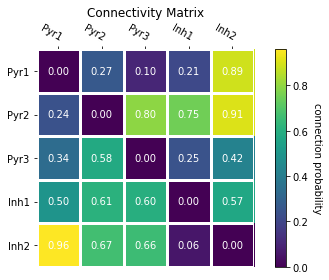

In [9]:
fig, ax = plt.subplots()

im, cbar = heatmap(weight_matrix, ['Pyr1', 'Pyr2', 'Pyr3', 'Inh1', 'Inh2'], ['Pyr1', 'Pyr2', 'Pyr3','Inh1', 'Inh2'], ax=ax, cmap="viridis", cbarlabel="connection probability")

fig.tight_layout()

# Ex2. Connect your cells considering connection probability

<font size='3'>Connect your five cells as it is done in tutorial 02, considering the following connection probabilities between cell types:
<br> PC - PC: 75 %
<br> PC - Inh: 19 %
<br> Inh - PC: 48 %
<br> Inh - Inh: 23 %

<font size='3'>Show the results on a probability matrix and the number of contacts each of your cells has. [1 pt]

<span style="color:red"> Restaring Kernel out of precaution...
    
    
### Step 1: Creating Cell Class

In [10]:
# Importing usefull packages:
%matplotlib inline

from neuron import h, gui
import matplotlib.pyplot as plt
import numpy as np

class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()
        
    def build_morphology(self, filename):
        h.load_file('import3d.hoc')
        h.load_file('stdlib.hoc')
        #morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(self) # Notice this change to be able to instantiate several cells
    
    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
        
        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        if hasattr(self, 'apic'):
            for sec in self.apic:
                sec.insert('hh')
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        for sec in self.dend:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
                
        for sec in self.axon:
            sec.insert('hh')
            for seg in sec:    
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

### Step 2: Instanciate our Cells from Homework 2

In [11]:
Pyr1 = Cell('morph_06.swc','Pyr1','Pyr')
Pyr2 = Cell('morph_07.swc','Pyr2','Pyr')
Pyr3 = Cell('morph_09.swc','Pyr3','Pyr')
Int1 = Cell('morph_03.swc','Int1','Int')
Int2 = Cell('morph_10.swc','Int2','Int')

# Classing the cells by group:
cells_Pyr = [Pyr1, Pyr2, Pyr3]
cells_Int = [Int1, Int2]
cells = cells_Pyr + cells_Int

error morph_06.swc line 17828: could not parse: 
error morph_07.swc line 19678: could not parse: 
error morph_09.swc line 6173: could not parse: 
error morph_03.swc line 7281: could not parse: 
error morph_10.swc line 3377: could not parse: 


In [12]:
for c in cells_Pyr:
    print('%s: %d apical sections, %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.apic),len(c.dend), len(c.soma), len(c.axon)))
for c in cells_Int:
    print('%s: %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.dend), len(c.soma), len(c.axon)))

Pyr1: 95 apical sections, 72 basal sections, 2 soma sections and 131 axon senctions
Pyr2: 131 apical sections, 82 basal sections, 2 soma sections and 125 axon senctions
Pyr3: 37 apical sections, 69 basal sections, 2 soma sections and 67 axon senctions
Int1: 45 basal sections, 2 soma sections and 103 axon senctions
Int2: 33 basal sections, 2 soma sections and 120 axon senctions


### Step 3: Connecting Cells based on Connection Probabilities

In [13]:
# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(source, target, weight = None, delay = 5, source_sec = None, source_neurite = 'axon', target_sec = None, target_neurite = 'dend'):
    rng = np.random.default_rng()
    
    if weight is None:
        weight = rng.uniform() # random weight
    
    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0,len(target_neurite_)) # random dendritic section
    
    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0,len(source_neurite_)) # random axonal section
    
    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn) # store synapse
    
    netcon = h.NetCon(source_neurite_[source_sec](0.5)._ref_v, target_syn, sec=source_neurite_[source_sec])
    netcon.weight[0] = weight
    netcon.delay = delay
    
    print('Connected cells %s -> %s with weight %g and delay %g, from %s[%d] to %s[%d]' % (source.name,target.name,weight,delay,source_neurite,source_sec,target_neurite,target_sec))
    return netcon

In [14]:
# specify connection probabilites between cell types
conn_prob_matrix = np.zeros((2,2))
conn_prob_matrix[0,0] = 0.75 # Pyr to Pyr
conn_prob_matrix[0,1] = 0.19 # Pyr to Int
conn_prob_matrix[1,0] = 0.48 # Int to Pyr
conn_prob_matrix[1,1] = 0.23 # Int to Int

In [15]:
netcons = [] # store all netcons

rng = np.random.default_rng()

################ Pyramidal 1
# Connect Pyr2 to Pyr1
if rng.random() < conn_prob_matrix[0,0]:
    nc = connect(Pyr2, Pyr1)
    netcons.append(nc)
    
# Connect Pyr3 to Pyr1
if rng.random() < conn_prob_matrix[0,0]:
    nc = connect(Pyr3, Pyr1)
    netcons.append(nc)

# Connect Int1 to Pyr1
if rng.random() < conn_prob_matrix[1,0]:
    nc = connect(Int1, Pyr1, target_neurite='soma')
    netcons.append(nc)

# Connect Int2 to Pyr1
if rng.random() < conn_prob_matrix[1,0]:
    nc = connect(Int2, Pyr1, target_neurite='soma')
    netcons.append(nc)

################ Pyramidal 2
# Connect Pyr1 to Pyr2
if rng.random() < conn_prob_matrix[0,0]:
    nc = connect(Pyr2, Pyr2)
    netcons.append(nc)
    
# Connect Pyr3 to Pyr2
if rng.random() < conn_prob_matrix[0,0]:
    nc = connect(Pyr3, Pyr2)
    netcons.append(nc)

# Connect Int1 to Pyr2
if rng.random() < conn_prob_matrix[1,0]:
    nc = connect(Int1, Pyr2, target_neurite='soma')
    netcons.append(nc)

# Connect Int2 to Pyr2
if rng.random() < conn_prob_matrix[1,0]:
    nc = connect(Int2, Pyr2, target_neurite='soma')
    netcons.append(nc)

################ Pyramidal 3
# Connect Pyr1 to Pyr3
if rng.random() < conn_prob_matrix[0,0]:
    nc = connect(Pyr1, Pyr2)
    netcons.append(nc)
    
# Connect Pyr2 to Pyr3
if rng.random() < conn_prob_matrix[0,0]:
    nc = connect(Pyr2, Pyr3)
    netcons.append(nc)

# Connect Int1 to Pyr3
if rng.random() < conn_prob_matrix[1,0]:
    nc = connect(Int1, Pyr3, target_neurite='soma')
    netcons.append(nc)

# Connect Int2 to Pyr3
if rng.random() < conn_prob_matrix[1,0]:
    nc = connect(Int2, Pyr3, target_neurite='soma')
    netcons.append(nc)

################ Inhibitory 1
# Connect Pyr1 to Int1
if rng.random() < conn_prob_matrix[0,1]:
    nc = connect(Pyr1, Int1)
    netcons.append(nc)

# Connect Pyr2 to Int1
if rng.random() < conn_prob_matrix[0,1]:
    nc = connect(Pyr2, Int1)
    netcons.append(nc)

# Connect Pyr3 to Int1
if rng.random() < conn_prob_matrix[0,1]:
    nc = connect(Pyr3, Int1)
    netcons.append(nc)

# Connect Int2 to Int1
if rng.random() < conn_prob_matrix[1,1]:
    nc = connect(Int2, Int1, target_neurite='soma')
    netcons.append(nc)

################ Inhibitory 2
# Connect Pyr1 to Int2
if rng.random() < conn_prob_matrix[0,1]:
    nc = connect(Pyr1, Int2)
    netcons.append(nc)

# Connect Pyr2 to Int2
if rng.random() < conn_prob_matrix[0,1]:
    nc = connect(Pyr2, Int2)
    netcons.append(nc)

# Connect Pyr3 to Int2
if rng.random() < conn_prob_matrix[0,1]:
    nc = connect(Pyr3, Int2)
    netcons.append(nc)

# Connect Int1 to Int2
if rng.random() < conn_prob_matrix[1,1]:
    nc = connect(Int1, Int2, target_neurite='soma')
    netcons.append(nc)

Connected cells Pyr3 -> Pyr1 with weight 0.994685 and delay 5, from axon[3] to dend[53]
Connected cells Int1 -> Pyr1 with weight 0.0866629 and delay 5, from axon[46] to soma[0]
Connected cells Pyr2 -> Pyr2 with weight 0.268783 and delay 5, from axon[63] to dend[9]
Connected cells Pyr3 -> Pyr2 with weight 0.866126 and delay 5, from axon[13] to dend[6]
Connected cells Int1 -> Pyr2 with weight 0.458499 and delay 5, from axon[11] to soma[0]
Connected cells Int2 -> Pyr2 with weight 0.821092 and delay 5, from axon[100] to soma[1]
Connected cells Pyr2 -> Pyr3 with weight 0.169115 and delay 5, from axon[75] to dend[15]
Connected cells Int1 -> Pyr3 with weight 0.469477 and delay 5, from axon[12] to soma[1]
Connected cells Pyr1 -> Int2 with weight 0.31316 and delay 5, from axon[103] to dend[14]
Connected cells Pyr3 -> Int2 with weight 0.41244 and delay 5, from axon[8] to dend[14]
Connected cells Int1 -> Int2 with weight 0.328775 and delay 5, from axon[86] to soma[0]


In [16]:
print(len(netcons))

11


### Step 4: Probability Matrix and number of contacts each of our cell has

#### -->Displaying Connection Probability Matrix (between cell types)

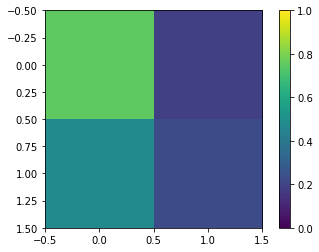

In [17]:
# Displaying Connection Probability Matrix (between cell types)
plt.imshow(conn_prob_matrix, cmap="viridis", vmin=0.0, vmax=1.0)
plt.colorbar()

#### -->Displaying Connection Probability Matrix (between all the different cells)

In [18]:
# Creating the Weight Matrix that will be plotted as a Heatmap
weight_matrix = np.zeros((5,5))
cellnames = [x.name for x in cells]

for nc in netcons:
    pre = nc.precell().name
    pos = nc.postcell().name
    ipre = cellnames.index(pre)
    ipos = cellnames.index(pos)
    weight_matrix[ipre,ipos] = nc.weight[0]
    

In [19]:
# Displaying Connection Probability Matrix (between all the different cells)

def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(5):
        for j in range(5):
            text = ax.text(j, i, "%.2f" %data[i, j],
                           ha="center", va="center", color="w")
    
    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_title("Connectivity Matrix")
    
    
    return im, cbar

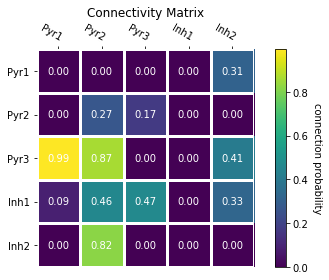

In [20]:
fig, ax = plt.subplots()

im, cbar = heatmap(weight_matrix, ['Pyr1', 'Pyr2', 'Pyr3', 'Inh1', 'Inh2'], ['Pyr1', 'Pyr2', 'Pyr3','Inh1', 'Inh2'], ax=ax, cmap="viridis", cbarlabel="connection probability")

fig.tight_layout()

### -->Number of contacts for each of our cell

In [21]:
## Printing the number of contacts each of our cell has:

print("In total, "+str(len(netcons))+' connections were made')

count_pyr1 = 0
count_pyr2 = 0
count_pyr3 = 0
count_inh1 = 0
count_inh2 = 0

for nc in netcons:
    pre = nc.precell().name
    ipre = cellnames.index(pre)
    if ipre == 0: # Pyramidal cell 1
        count_pyr1 += 1
    if ipre == 1: # Pyramidal cell 2
        count_pyr2 += 1
    if ipre == 2: # Pyramidal cell 3
        count_pyr3 += 1
    if ipre == 3: # Inhibitory cell 1
        count_inh1 += 1
    if ipre == 4: # Inhibitory cell 2
        count_inh2 += 1

print("Pyramidal cell 1 made "+str(count_pyr1)+" contacts")
print("Pyramidal cell 2 made "+str(count_pyr2)+" contacts")
print("Pyramidal cell 3 made "+str(count_pyr3)+" contacts")
print("Inhibitory cell 1 made "+str(count_inh1)+" contacts")
print("Inhibitory cell 2 made "+str(count_inh2)+" contacts")

In total, 11 connections were made
Pyramidal cell 1 made 1 contacts
Pyramidal cell 2 made 2 contacts
Pyramidal cell 3 made 3 contacts
Inhibitory cell 1 made 4 contacts
Inhibitory cell 2 made 1 contacts


# Ex3. Distribution of contacts: Convergence Matrix

<font size='3'>Considering the following mean contact points between cell types: 
<br> PC_axon - PC_basal: 3
<br> PC_axon - PC_apical: 1.5
<br> PC_axon - Inh_basal: 4
<br> Inh_axon - PC_soma: 3.5
<br> Inh_axon - PC_basal: 2.2
<br> Inh_axon - Inh_soma: 3.8
<br> Inh_axon - Inh_basal: 1.9

<font size='3'>Connect your cells by selecting the contact points from a normal distribution with a specific mean value per connection (values above). What is the maximum number of contacts you observe in your connectome ? Between which two cells ? Show the results on a __convergence__ matrix (how many contacts each of the cells receives from the others). [1.5 pts] 

<span style="color:red"> Restarting Kernel out of precaution...

### Step 1: Defining Cell Class

In [22]:
# Load usefull packages
%matplotlib inline

from neuron import h, gui
import matplotlib.pyplot as plt
import numpy as np
import math as m

In [23]:
class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()
        
    def build_morphology(self, filename):
        h.load_file('import3d.hoc')
        h.load_file('stdlib.hoc')
        #morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(self)
    
    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
        
        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        if hasattr(self, 'apic'):
            for sec in self.apic:
                sec.insert('hh')
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        for sec in self.dend:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
                
        for sec in self.axon:
            sec.insert('hh')
            for seg in sec:    
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

### Step 2: Instanciating the Cells from Homework 2

In [24]:
Pyr1 = Cell('morph_06.swc','Pyr1','Pyr')
Pyr2 = Cell('morph_07.swc','Pyr2','Pyr')
Pyr3 = Cell('morph_09.swc','Pyr3','Pyr')
Int1 = Cell('morph_03.swc','Int1','Int')
Int2 = Cell('morph_10.swc','Int2','Int')

# Classing the cells by group:
cells_Pyr = [Pyr1, Pyr2, Pyr3]
cells_Int = [Int1, Int2]
cells = cells_Pyr + cells_Int

error morph_06.swc line 17828: could not parse: 
error morph_07.swc line 19678: could not parse: 
error morph_09.swc line 6173: could not parse: 
error morph_03.swc line 7281: could not parse: 
error morph_10.swc line 3377: could not parse: 


In [25]:
for c in cells_Pyr:
    print('%s: %d apical sections, %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.apic),len(c.dend), len(c.soma), len(c.axon)))
for c in cells_Int:
    print('%s: %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.dend), len(c.soma), len(c.axon)))

Pyr1: 95 apical sections, 72 basal sections, 2 soma sections and 131 axon senctions
Pyr2: 131 apical sections, 82 basal sections, 2 soma sections and 125 axon senctions
Pyr3: 37 apical sections, 69 basal sections, 2 soma sections and 67 axon senctions
Int1: 45 basal sections, 2 soma sections and 103 axon senctions
Int2: 33 basal sections, 2 soma sections and 120 axon senctions


### Step 3: Connecting Cells by selecting contact point distribution

In [26]:
# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(source, target, weight = None, delay = 5, source_sec = None, source_neurite = 'axon', target_sec = None, target_neurite = 'dend'):
    rng = np.random.default_rng()
    
    if weight is None:
        weight = rng.uniform() # random weight
    
    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0,len(target_neurite_)) # random dendritic section
    
    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0,len(source_neurite_)) # random axonal section
    
    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn) # store synapse
    
    netcon = h.NetCon(source_neurite_[source_sec](0.5)._ref_v, target_syn, sec=source_neurite_[source_sec])
    netcon.weight[0] = weight
    netcon.delay = delay
    
    print('Connected cells %s -> %s with weight %g and delay %g, from %s[%d] to %s[%d]' % (source.name,target.name,weight,delay,source_neurite,source_sec,target_neurite,target_sec))
    return netcon

In [27]:
# specify connection probabilites between cell types
conn_prob_matrix = np.zeros((2,2))
conn_prob_matrix[0,0] = 0.75 # Pyr to Pyr
conn_prob_matrix[0,1] = 0.19 # Pyr to Int
conn_prob_matrix[1,0] = 0.48 # Int to Pyr
conn_prob_matrix[1,1] = 0.23 # Int to Int

In [28]:
# specify expected number of contacts between cell types, considering target neurite
expected_contacts = np.zeros((2,2,3), dtype=int)

expected_contacts[0,0,0] = 0 # Pyr to Pyr (soma)
expected_contacts[0,0,1] = 3 # Pyr to Pyr (dend)
expected_contacts[0,0,2] = 1.5 # Pyr to Pyr (apic)

expected_contacts[1,0,0] = 3.5 # Int to Pyr (soma)
expected_contacts[1,0,1] = 2.2 # Int to Pyr (dend)
expected_contacts[1,0,2] = 0 # Int to Pyr (apic)

expected_contacts[0,1,0] = 0 # Pyr to Int (soma)
expected_contacts[0,1,1] = 4 # Pyr to Int (dend)

expected_contacts[1,1,0] = 3.8 # Int to Int (soma)
expected_contacts[1,1,1] = 1.9 # Int to Int (dend)

In [29]:
# generate number of contacts per cell type, by selecting them from a normal distribution 
# in which the mean is the expected_contacts value

netcons = [] # store all netcons

rng = np.random.default_rng()

############ Pyramidal 1
# Connect Pyr2 to Pyr1
if rng.random() < conn_prob_matrix[0,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[0,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr2, Pyr1, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr3 to Pyr1
if rng.random() < conn_prob_matrix[0,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[0,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr3, Pyr1, target_neurite=neurite)
            netcons.append(nc)

# Connect Int1 to Pyr1
if rng.random() < conn_prob_matrix[1,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[1,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Int1, Pyr1, target_neurite=neurite)
            netcons.append(nc)
            
# Connect Int2 to Pyr1
if rng.random() < conn_prob_matrix[1,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[1,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Int2, Pyr1, target_neurite=neurite)
            netcons.append(nc)

############ Pyramidal 2
# Connect Pyr1 to Pyr2
if rng.random() < conn_prob_matrix[0,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[0,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr1, Pyr2, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr3 to Pyr2
if rng.random() < conn_prob_matrix[0,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[0,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr3, Pyr2, target_neurite=neurite)
            netcons.append(nc)

# Connect Int1 to Pyr2
if rng.random() < conn_prob_matrix[1,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[1,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Int1, Pyr2, target_neurite=neurite)
            netcons.append(nc)
            
# Connect Int2 to Pyr2
if rng.random() < conn_prob_matrix[1,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[1,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Int2, Pyr2, target_neurite=neurite)
            netcons.append(nc)

############ Pyramidal 3
# Connect Pyr1 to Pyr3
if rng.random() < conn_prob_matrix[0,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[0,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr1, Pyr3, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr2 to Pyr3
if rng.random() < conn_prob_matrix[0,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[0,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr2, Pyr3, target_neurite=neurite)
            netcons.append(nc)

# Connect Int1 to Pyr3
if rng.random() < conn_prob_matrix[1,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[1,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Int1, Pyr3, target_neurite=neurite)
            netcons.append(nc)
            
# Connect Int2 to Pyr3
if rng.random() < conn_prob_matrix[1,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[1,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Int2, Pyr3, target_neurite=neurite)
            netcons.append(nc)

############ Inhibitory 1
# Connect Pyr1 to Int1
if rng.random() < conn_prob_matrix[0,1]:
    for i,neurite in enumerate(['soma','dend']):
        contacts = expected_contacts[0,1,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr1, Int1, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr2 to Int1
if rng.random() < conn_prob_matrix[0,1]:
    for i,neurite in enumerate(['soma','dend']):
        contacts = expected_contacts[0,1,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr2, Int1, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr3 to Int1
if rng.random() < conn_prob_matrix[0,1]:
    for i,neurite in enumerate(['soma','dend']):
        contacts = expected_contacts[0,1,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr3, Int1, target_neurite=neurite)
            netcons.append(nc)

# Connect Int2 to Int1
if rng.random() < conn_prob_matrix[1,1]:
    for i,neurite in enumerate(['soma','dend']):
        contacts = expected_contacts[1,1,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Int2, Int1, target_neurite=neurite)
            netcons.append(nc)

############ Inhibitory 2
# Connect Pyr1 to Int2
if rng.random() < conn_prob_matrix[0,1]:
    for i,neurite in enumerate(['soma','dend']):
        contacts = expected_contacts[0,1,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr1, Int2, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr2 to Int2
if rng.random() < conn_prob_matrix[0,1]:
    for i,neurite in enumerate(['soma','dend']):
        contacts = expected_contacts[0,1,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr2, Int2, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr3 to Int2
if rng.random() < conn_prob_matrix[0,1]:
    for i,neurite in enumerate(['soma','dend']):
        contacts = expected_contacts[0,1,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Pyr3, Int2, target_neurite=neurite)
            netcons.append(nc)

# Connect Int1 to Int2
if rng.random() < conn_prob_matrix[1,1]:
    for i,neurite in enumerate(['soma','dend']):
        contacts = expected_contacts[1,1,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            nc = connect(Int1, Int2, target_neurite=neurite)
            netcons.append(nc)

Connected cells Pyr2 -> Pyr1 with weight 0.325292 and delay 5, from axon[63] to dend[16]
Connected cells Pyr2 -> Pyr1 with weight 0.697693 and delay 5, from axon[88] to dend[19]
Connected cells Pyr2 -> Pyr1 with weight 0.71405 and delay 5, from axon[116] to dend[3]
Connected cells Int2 -> Pyr1 with weight 0.985602 and delay 5, from axon[67] to soma[0]
Connected cells Int2 -> Pyr1 with weight 0.0412634 and delay 5, from axon[45] to soma[1]
Connected cells Int2 -> Pyr1 with weight 0.25047 and delay 5, from axon[92] to dend[37]
Connected cells Int2 -> Pyr1 with weight 0.467512 and delay 5, from axon[98] to dend[70]
Connected cells Pyr3 -> Pyr2 with weight 0.66406 and delay 5, from axon[27] to dend[54]
Connected cells Pyr3 -> Pyr2 with weight 0.296535 and delay 5, from axon[57] to dend[43]
Connected cells Int1 -> Pyr2 with weight 0.775922 and delay 5, from axon[30] to soma[0]
Connected cells Int1 -> Pyr2 with weight 0.930918 and delay 5, from axon[29] to soma[0]
Connected cells Int1 -> Pyr

In [30]:
len(netcons)

30

### What is the maximum number of contacts you observe in your connectome ? Between which two cells ? Show the results on a convergence matrix (how many contacts each of the cells receives from the others).

#### --> Computing maximum number of contacts:

In [31]:
cellnames = [x.name for x in cells]

pyr_1_contacts = np.zeros((1,5))
pyr_2_contacts = np.zeros((1,5))
pyr_3_contacts = np.zeros((1,5))
int_1_contacts = np.zeros((1,5))
int_2_contacts = np.zeros((1,5))

# iterate over netcons and count
for nc in netcons:
    pre = nc.precell().name
    pos = nc.postcell().name
    ipre = cellnames.index(pre)
    ipos = cellnames.index(pos)
    if ipre == 0:
        pyr_1_contacts[0][ipos] += 1
    if ipre == 1:
        pyr_2_contacts[0][ipos] += 1
    if ipre == 2:
        pyr_3_contacts[0][ipos] += 1
    if ipre == 3:
        int_1_contacts[0][ipos] += 1
    if ipre == 4:
        int_2_contacts[0][ipos] += 1


print("For pyramidal cell 1, it made at most "+str(int(np.max(pyr_1_contacts)))+' with '+str(cellnames[np.argmax(pyr_1_contacts)]))
print("For pyramidal cell 2, it made at most "+str(int(np.max(pyr_2_contacts)))+' with '+str(cellnames[np.argmax(pyr_2_contacts)]))
print("For pyramidal cell 3, it made at most "+str(int(np.max(pyr_3_contacts)))+' with '+str(cellnames[np.argmax(pyr_3_contacts)]))
print("For inhibitory cell 1, it made at most "+str(int(np.max(int_1_contacts)))+' with '+str(cellnames[np.argmax(int_1_contacts)]))
print("For inhibitory cell 2, it made at most "+str(int(np.max(int_2_contacts)))+' with '+str(cellnames[np.argmax(int_2_contacts)]))

For pyramidal cell 1, it made at most 2 with Pyr3
For pyramidal cell 2, it made at most 3 with Pyr1
For pyramidal cell 3, it made at most 2 with Pyr2
For inhibitory cell 1, it made at most 3 with Pyr2
For inhibitory cell 2, it made at most 6 with Pyr3


In this particular connectome, we can deduce that the maximal number of contacts made was 5, and it was between inhibitory cell 2 and pyramidal cell 2.

#### --> Computing maximum number of contacts:

In [32]:
# Convergence Matrix:

convergence_matrix = np.zeros((5,5))
cellnames = [x.name for x in cells]

# iterate over netcons and count
for nc in netcons:
    pre = nc.precell().name
    pos = nc.postcell().name
    ipre = cellnames.index(pre)
    ipos = cellnames.index(pos)
    convergence_matrix[ipos,ipre] += 1 

In [33]:
# Displaying Connection Probability Matrix (between all the different cells)

def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(5):
        for j in range(5):
            text = ax.text(j, i, "%.0f" %data[i, j],
                           ha="center", va="center", color="w")
    
    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_title("Convergence Matrix")
    
    
    return im, cbar

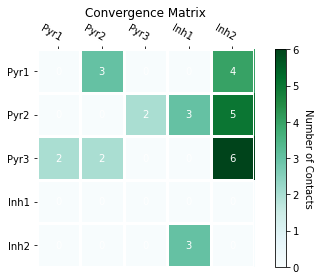

In [34]:
fig, ax = plt.subplots()

im, cbar = heatmap(convergence_matrix, ['Pyr1', 'Pyr2', 'Pyr3', 'Inh1', 'Inh2'], ['Pyr1', 'Pyr2', 'Pyr3','Inh1', 'Inh2'], ax=ax, cmap="BuGn", cbarlabel="Number of Contacts")

fig.tight_layout()

# Ex4. Real Connectivity Rules

<font size='3'>Read the articles uploaded on the HomeWork folder (Markram_1997.pdf and Gupta_2000.pdf). 

<font size='3'>Imaging that you have to build a network with your five cells (3 pyramidals and 2 GABAergic interneurons) from rat somatosensory cortex. Extract from the papers the data that you would need to connect your cells (connectivity rules). Enumerate the data chosen to connect your cells. Using and modifying (if needed) the code from the tutorials, connect your five cells in a more biological way using the connectivity rules found in the papers. [2.5 pts]

#### Connectivity rules for the Pyramidal Excitatory Cells: (Markram 1997):

According to the paper:

- For both unidirectional and bidirectional:
    - the synaptic connections between pairs of pyramidal neurons 70% were unidirectional and 30% were bidirectional
    - Probability of finding a synaptic correction in dual recordings was: 0.1% (but this could be higher if no artefacts introduced with to the brain slices)
    - number of potential synaptic contacts formed by a presynaptic neuron on a target neuron varied between 4 and 8 (mean 5.5 contacts)
    - synaptic contacts were preferentially located on basal dendrites (63%), and apical oblique dendrites (27%) and 35% of all contacts were located on tertiatry basal dendritic branches
    
- For unidirectional synaptic connections:
   - five or more contacts were established with the target neuron and these contacts were found on the entire dendritic tree
   - 58% of all potential synaptic contacts identified were located on basal dendrites (of these, 91% were located on secondary and tertiary dendritic branches), and tertiary dendritic branches are at a distance of 60-100 µm from the soma
   
- For bidirectional synaptic connections:
    - mean number of potential synaptic connections on target neurons is 5.5
    - distribution of synaptic contacts was also similar to that found on target neurons of unidirectional pairs
    - of all potential synaptic contacts identified: (66.7%) was located on basal dendrites

#### Connectivity rules for the Inhibitory Interneuron Cells: (Gupta 2000):

According to this paper:

- 800 quadruple recordings, yielding 3000 potential GABAergic connections, and there were more than 240 GABAergic connections (this gives us the inhibitory to other cell connection probabiilty)
- The GABAertic connections are characterized into 3 types according:
    - F1 (facilitated recovery test response (RTR)) (13.4%)
    - F2 (depressed RTR) (71.5%)
    - F3 (recovered RTR) (15.1%)
- For each of these 3 classification, the connectivity probability identified, as well as the number of synapses that were present:
    - for F1:
        - IN to PC: 7.6%
        - IN to IN: 29.2%
        - number of contacts: 9.3
    - for F2:
        - IN to PC: 76.3%
        - IN to IN: 58.3%
        - number of contacts: 16
    - for F3:
        - IN to PC: 16%
        - IN to IN: 12.5%
        - number of cnotacts: 16.7
- Moreover, according to the type of interneuron we are considering, the type of synapse that is present differs (for instance, for basket cells, there are only F2 synapses), see table 2 for more information
- Furthermore, to identify where the conctacts are distributed (on soma or on dendrites), we use the information provided by the "anatomical diversity of GABAergic Interneurons", giving some percentages for where the interneurons are contacting:
    - for basket cells: 19% of the contacts made are to the somata of the target cells
    - for the small basket cells: 5% form synapses on the somata of the target cells

#### Enumerating the data we are going to use to connect our cells:

According to the papers above:

- For our pyramidal cells:
    - the connection probability for pyramidal to pyramidal cells is 0.1
    - according to the first article, 70% of the pyramidal cells were characterized as being unidirectional, and 30% as bidirectional. However, given that the paper indicates that the values number of contacts are similar between unidirectional and bidirectional cells (at around 5.5)
    - Moreover, given that the percentages were also very similar between unidirectional and bidirectional distribution to the basal or apical dendrites, we are considering:
        - that 58% of the contacts made are on basal dendrites
        - the remaining 42% are on apical dendrites

   - We specified where those contacts were made according to the distance from the soma, as was done in the paper (Table 3) by:
        - randomly selecting sections that were closer than 100µm from the soma for the basal dendrites
        - randomly selecting sections that were farther than 100 µm from the soma for the apical dendrites
        
        
- For our interneurons:
    - We took a look at the morphology of the two interneurons we were considering, in order to see what type they were:

In [35]:
import neurom as nm
from neurom import viewer
from neurom.view import view
from neurom.view.common import update_plot_limits
import matplotlib.pyplot as plt

#Get Neuron Path, Load Neuron Morphology, Extract Neurites from Neuron object
nrn = 'morph_03.swc'
neuron = nm.load_neuron(nrn)
neurites = neuron.neurites

# Create Figure to include all subplots
fig = plt.figure(figsize=(10, 40))

# Plot neuron in 3D in a subplot
axes = fig.add_subplot(12, 2, (1,4), projection='3d') # Add to the last subplot
nm.viewer.plot_neuron3d(axes, neuron)
axes.set_ylim((-1000, 1000))
axes.set_xlim((-1000, 1000))
axes.set_zlim(-200,200)
axes.set_title('3D')

# Plot Neuron in 2D in 3 planes
planes = ['xy', 'xz', 'yz']
for i, plane in enumerate(planes):
    axes = fig.add_subplot(12, 2, i+5)
    nm.viewer.plot_neuron(axes, neuron, plane=plane)
    axes.set_ylim((-500, 500))
    axes.set_xlim((-1000, 1000))
    axes.set_title(str(plane))

# Plot Neurites separately
for i, neurite in enumerate(neurites):
    current_axes = fig.add_subplot(12, 2, i+8)
    view.plot_tree(current_axes, neurite, plane='xy')
    update_plot_limits(current_axes, white_space=10)
    current_axes.set_title(str(neurite.type).split('.')[1])

# set a global title for the figure
fig.suptitle(neuron.name, y=1, fontsize=20)
fig.tight_layout()

Error in callback <function flush_figures at 0x7fe145784950> (for post_execute):


KeyboardInterrupt: 

In [36]:
import neurom as nm
from neurom import viewer
from neurom.view import view
from neurom.view.common import update_plot_limits
import matplotlib.pyplot as plt

#Get Neuron Path, Load Neuron Morphology, Extract Neurites from Neuron object
nrn = 'morph_10.swc'
neuron = nm.load_neuron(nrn)
neurites = neuron.neurites

# Create Figure to include all subplots
fig = plt.figure(figsize=(10, 40))

# Plot neuron in 3D in a subplot
axes = fig.add_subplot(12, 2, (1,4), projection='3d') # Add to the last subplot
nm.viewer.plot_neuron3d(axes, neuron)
axes.set_ylim((-1000, 1000))
axes.set_xlim((-1000, 1000))
axes.set_zlim(-200,200)
axes.set_title('3D')

# Plot Neuron in 2D in 3 planes
planes = ['xy', 'xz', 'yz']
for i, plane in enumerate(planes):
    axes = fig.add_subplot(12, 2, i+5)
    nm.viewer.plot_neuron(axes, neuron, plane=plane)
    axes.set_ylim((-500, 500))
    axes.set_xlim((-1000, 1000))
    axes.set_title(str(plane))

# Plot Neurites separately
for i, neurite in enumerate(neurites):
    current_axes = fig.add_subplot(12, 2, i+8)
    view.plot_tree(current_axes, neurite, plane='xy')
    update_plot_limits(current_axes, white_space=10)
    current_axes.set_title(str(neurite.type).split('.')[1])

# set a global title for the figure
fig.suptitle(neuron.name, y=1, fontsize=20)
fig.tight_layout()

Error in callback <function flush_figures at 0x7fe145784950> (for post_execute):


KeyboardInterrupt: 

- From observing the morphologies, we deduced that:
    - interneuron 03 was: a basket cell
    - interneuron 10 was: a small basket cell

- With this information and looking at table 2, one can notice the type of GABAergic synapse of the interneuron we are considering:
    - the basket cell have GABAergic F2 synapses
    - the small basket cell forms GABAergic F1, F2 and F3 synapses
        - in this case, given that the majority of the synapses from the paper are of type F2, we also selected the GABAergic synapses to be of type F2

- With these assumptions, we can deduce the connection probabilities and the number of contacts:
    - connectivity from inhibitory to pyramidal: 76.3%
    - connectivity from inhibitory to inhibitory: 58.3%
    - number of contacts: 16

- For the basket cells: 19% of those contacts are on the soma of the target cell
    - It was not specified how the remaining 81% were distributed: as a result we will distribute them randomly
- For the small baket cells: 5% of those contacts are on the soma of the target cell
    - It was not specifed how the remainning 95% were distributed: as a result we will distributed them randomly

In both papers above, the connection probability was not mentionned from pyramidal to interneurons.  As a result, we refered to ["Pyramidal Cell-Interneuron Circuit Architecture and Dynamics in Hippocampal Networks"](https://www.cell.com/neuron/pdfExtended/S0896-6273(17)30902-9), in order to obtain a connection probability of 0.2 from pyramidal cells to interneurons.

- given that we were not able to find the corresponding number of contacts or an adequate paper giving the correct number of contacts, we used the value which was given in exercise 3 (meaning we have PC_axon $\rightarrow$ Inh_basal equal to 4)

NB: We also checked out the paper ["Parvalbumin+ interneurons obey unique connectivity rules and establish a powerful lateral-inhibition microcircuit in dentate gyrus"](https://www.nature.com/articles/s41467-018-06899-3), which provided connectivity probability values which where of the same order as those we considered above.

Now let's create our connections!

### Step 1: Creating Cell Class

In [1]:
# Importing usefull packages:
%matplotlib inline

from neuron import h, gui
import matplotlib.pyplot as plt
import numpy as np

class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()
        
    def build_morphology(self, filename):
        h.load_file('import3d.hoc')
        h.load_file('stdlib.hoc')
        #morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(self)
    
    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
        
        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        if hasattr(self, 'apic'):
            for sec in self.apic:
                sec.insert('hh')
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        for sec in self.dend:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
                
        for sec in self.axon:
            sec.insert('hh')
            for seg in sec:    
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

### Step 2: Instanciating the Cells from Homework 2

In [2]:
Pyr1 = Cell('morph_06.swc','Pyr1','Pyr')
Pyr2 = Cell('morph_07.swc','Pyr2','Pyr')
Pyr3 = Cell('morph_09.swc','Pyr3','Pyr')
Int1 = Cell('morph_03.swc','Int1','Int')
Int2 = Cell('morph_10.swc','Int2','Int')

# Classing the cells by group:
cells_Pyr = [Pyr1, Pyr2, Pyr3]
cells_Int = [Int1, Int2]
cells = cells_Pyr + cells_Int

error morph_06.swc line 17828: could not parse: 
error morph_07.swc line 19678: could not parse: 
error morph_09.swc line 6173: could not parse: 
error morph_03.swc line 7281: could not parse: 
error morph_10.swc line 3377: could not parse: 


In [3]:
for c in cells_Pyr:
    print('%s: %d apical sections, %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.apic),len(c.dend), len(c.soma), len(c.axon)))
for c in cells_Int:
    print('%s: %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.dend), len(c.soma), len(c.axon)))

Pyr1: 95 apical sections, 72 basal sections, 2 soma sections and 131 axon senctions
Pyr2: 131 apical sections, 82 basal sections, 2 soma sections and 125 axon senctions
Pyr3: 37 apical sections, 69 basal sections, 2 soma sections and 67 axon senctions
Int1: 45 basal sections, 2 soma sections and 103 axon senctions
Int2: 33 basal sections, 2 soma sections and 120 axon senctions


### Step 3: Connecting Cells based on Connection Probabilities

In [4]:
# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(source, target, weight = None, delay = 5, source_sec = None, source_neurite = 'axon', target_sec = None, target_neurite = 'dend'):
    rng = np.random.default_rng()
    
    if weight is None:
        weight = rng.uniform() # random weight
    
    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0,len(target_neurite_)) # random dendritic section
    
    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0,len(source_neurite_)) # random axonal section
    
    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn) # store synapse
    
    netcon = h.NetCon(source_neurite_[source_sec](0.5)._ref_v, target_syn, sec=source_neurite_[source_sec])
    netcon.weight[0] = weight
    netcon.delay = delay
    
    print('Connected cells %s -> %s with weight %g and delay %g, from %s[%d] to %s[%d]' % (source.name,target.name,weight,delay,source_neurite,source_sec,target_neurite,target_sec))
    return netcon

In [5]:
# specify connection probabilites between cell types
conn_prob_matrix = np.zeros((2,2))

conn_prob_matrix[0,0] = 0.1 # Pyr to Pyr
conn_prob_matrix[0,1] = 0.2 # Pyr to Int
conn_prob_matrix[1,0] = 0.76 # Int to Pyr
conn_prob_matrix[1,1] = 0.58 # Int to Int


In [6]:
# specify expected number of contacts between cell types, considering target neurite
expected_contacts = np.zeros((3,3,3), dtype=int)

expected_contacts[0,0,0] = 0 # Pyr to Pyr (soma)
expected_contacts[0,0,1] = 3.19 # Pyr to Pyr (basal) 58% of 5.5
expected_contacts[0,0,2] = 2.31 # Pyr to Pyr (apic) 42% of 5.5

# Considering the Basket Cell
expected_contacts[1,0,0] = 3.04 # Int_BC to Pyr (soma) 19% of 16
expected_contacts[1,0,1] = 6.48 # Int_BC to Pyr (dend) 40.5% of 16 (splitting the remaining contacts to the basal dendrites and the apical dendrites)
expected_contacts[1,0,2] = 6.48 # Int_BC to Pyr (apic) 40.5% of 16

# Considering the Small Basket Cell
expected_contacts[2,0,0] = 0.8 # Int_SBC to Pyr (soma) 5% of 16
expected_contacts[2,0,1] = 7.6 # Int_SBC to Pyr (dend) 95% of 16
expected_contacts[2,0,2] = 7.6 # Int_SBC to Pyr (apic) 95% of 16

# Considering the Basket Cell
expected_contacts[0,1,0] = 0 # Pyr to Int_BC (soma)
expected_contacts[0,1,1] = 4 # Pyr to Int_BC (dend)

# Considering the Small Basket Cell
expected_contacts[0,2,0] = 0 # Pyr to Int_SBC (soma)
expected_contacts[0,2,1] = 4 # Pyr to Int_SBC (dend)

# Considering the Basket Cell
expected_contacts[1,1,0] = 0 # Int_BC to Int_BC (soma)
expected_contacts[1,1,1] = 0 # Int_BC to Int_BC (dend)

# Considering the Small Basket Cell
expected_contacts[2,2,0] = 0 # Int_BC to Int_BC (soma)
expected_contacts[2,2,1] = 0 # Int_BC to Int_BC (dend)

# Considering the Basket Cell
expected_contacts[1,2,0] = 3.04 # Int_BC to Int_SBC (soma) 19% of 16
expected_contacts[1,2,1] = 12.96 # Int_BC to Int_SBC (dend) 81% of 16

# Considering the Small Basket Cell
expected_contacts[2,1,0] = 0.8 # Int_SBC to Int_BC (soma) 5% of 16
expected_contacts[2,1,1] = 15.2 # Int_SBC to Int_BC (dend) 95% of 16


In [9]:
def get_eligible_sec(cell):
    eligible_basal_sec = []
    eligible_apical_sec = []
    for sec in cell.dend:
        dist = h.distance(cell.soma[0](0), sec(0))
        if dist >= 60 and dist <= 100:
            eligible_basal_sec.append(sec)
    for sec in cell.apic:
        dist = h.distance(cell.soma[0](0), sec(0))
        if dist >= 100:
            eligible_apical_sec.append(sec) 
    return eligible_basal_sec, eligible_apical_sec

In [8]:
Pyr1_eligible_basal_sec, Pyr1_eligible_apical_sec = get_eligible_sec(Pyr1)
Pyr2_eligible_basal_sec, Pyr2_eligible_apical_sec = get_eligible_sec(Pyr2)
Pyr3_eligible_basal_sec, Pyr3_eligible_apical_sec = get_eligible_sec(Pyr3)

print('Number of Eligible Sections for connections in Pyr1 Basal/Apical: '+str(len(Pyr1_eligible_basal_sec))+'/' +str(len(Pyr1_eligible_apical_sec)))
print('Number of Eligible Sections for connections in Pyr2 Basal/Apical: '+str(len(Pyr2_eligible_basal_sec))+'/'  +str(len(Pyr2_eligible_apical_sec)))
print('Number of Eligible Sections for connections in Pyr3 Basal/Apical: '+str(len(Pyr3_eligible_basal_sec))+'/'  +str(len(Pyr3_eligible_apical_sec)))

NEURON: interpreter stack type error
 near line 0
 ^
        distance(..., ...)


RuntimeError: hoc error

In [ ]:
# generate number of contacts per cell type, by selecting them from a normal distribution 
# in which the mean is the expected_contacts value
import math as m

netcons = [] # store all netcons

rng = np.random.default_rng(5)

############ Pyramidal 1
# Connect Pyr2 to Pyr1
if rng.random() < conn_prob_matrix[0,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[0,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            if neurite == 'dend':
                rnd_num = np.random.randint(0,len(Pyr1_eligible_basal_sec))
            if neurite == 'apic':
                rnd_num = np.random.randint(0,len(Pyr1_eligible_apical_sec))
            nc = connect_ex4(Pyr2, Pyr1, target_sec = rnd_num, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr3 to Pyr1
if rng.random() < conn_prob_matrix[0,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[0,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            if neurite == 'dend':
                rnd_num = np.random.randint(0,len(Pyr1_eligible_basal_sec))
            if neurite == 'apic':
                rnd_num = np.random.randint(0,len(Pyr1_eligible_apical_sec))
            nc = connect_ex4(Pyr3, Pyr1, target_sec = rnd_num, target_neurite=neurite)
            netcons.append(nc)

############ Pyramidal 2
# Connect Pyr1 to Pyr2
if rng.random() < conn_prob_matrix[0,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[0,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            if neurite == 'dend':
                rnd_num = np.random.randint(0,len(Pyr2_eligible_basal_sec))
            if neurite == 'apic':
                rnd_num = np.random.randint(0,len(Pyr2_eligible_apical_sec))
            nc = connect_ex4(Pyr1, Pyr2, target_sec = rnd_num, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr3 to Pyr2
if rng.random() < conn_prob_matrix[0,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[0,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            if neurite == 'dend':
                rnd_num = np.random.randint(0,len(Pyr2_eligible_basal_sec))
            if neurite == 'apic':
                rnd_num = np.random.randint(0,len(Pyr2_eligible_apical_sec))
            nc = connect_ex4(Pyr3, Pyr2, target_sec = rnd_num, target_neurite=neurite)
            netcons.append(nc)

############ Pyramidal 3
# Connect Pyr1 to Pyr3
if rng.random() < conn_prob_matrix[0,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[0,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            if neurite == 'dend':
                rnd_num = np.random.randint(0,len(Pyr3_eligible_basal_sec))
            if neurite == 'apic':
                rnd_num = np.random.randint(0,len(Pyr3_eligible_apical_sec))
            nc = connect_ex4(Pyr1, Pyr3, target_sec = rnd_num, target_neurite=neurite)
            netcons.append(nc)

# Connect Pyr2 to Pyr3
if rng.random() < conn_prob_matrix[0,0]:
    for i,neurite in enumerate(['soma','dend','apic']):
        contacts = expected_contacts[0,0,i]
        if contacts > 0:
            contacts = m.floor(rng.normal(contacts))
        if contacts < 0:
            contacts = 0
        for i in range(0,contacts):
            if neurite == 'dend':
                rnd_num = np.random.randint(0,len(Pyr3_eligible_basal_sec))
            if neurite == 'apic':
                rnd_num = np.random.randint(0,len(Pyr3_eligible_apical_sec))
            nc = connect_ex4(Pyr2, Pyr3, target_sec = rnd_num, target_neurite=neurite)
            netcons.append(nc)

### Step 4: Probability Matrix and number of contacts each of our cell has